# Анализ оттока клиентов банка.

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Нам предстоит провести анализ данных, определить портрет пользователя, склонного уходить, проверить гипотезы, а также обучить модель, способную прогнозировать отток клиентов.


**Описание данных:**

Данный находятся в файле `bank_dataset.csv`.
Описание полей:
- `userid` — идентификатор пользователя;
- `score` — баллы кредитного скоринга;
- `City` — город;
- `Gender` — пол;
- `Age` — возраст;
- `Objects` — количество объектов в собственности;
- `Balance` — баланс на счёте;
- `Products` — количество продуктов, которыми пользуется клиент;
- `CreditCard` — есть ли кредитная карта;
- `Loyalty` — активный клиент;
- `estimated_salary` — заработная плата клиента;
- `Churn` — ушел или нет.

## Загрузка данных и изучение информации

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')  

Обновим seaborn, без этого гистограммы просто не строятся. Потом перезапустить тетрадку.

In [2]:
pip install seaborn==0.11.0

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_csv('/datasets/bank_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


10000 записей.12 колонок. Есть пропуски в балансе, типы данных корректны, название колонок нужно привести в нижний регистр.

## Шаг. Предобработка данных.

Создадим копию исходника и будем работать уже с ней. Переведем колонки в нижний регистр.

In [5]:
data = df.copy()
data.columns = data.columns.str.lower()

Проверим на пропуски и дубликаты.

In [6]:
data.isna().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

В `balance` много отсутствующих данных.

In [7]:
data['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

In [8]:
data[data['balance'].isna()].head(20) #посмотрим их, нет ли зависимостей?

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
11,15779909,497,Рыбинск,М,24,3,NaN,2,1,0,76390.01,0
12,15675000,476,Ярославль,Ж,34,10,NaN,2,1,0,26260.98,0
13,15734219,549,Ярославль,Ж,25,5,NaN,2,0,0,190857.79,0
14,15643618,635,Рыбинск,Ж,35,7,NaN,2,1,1,65951.65,0
17,15830954,549,Рыбинск,Ж,24,9,NaN,2,1,1,14406.41,0
18,15704243,587,Рыбинск,М,45,6,NaN,1,0,0,158684.81,0
19,15611718,726,Ярославль,Ж,24,6,NaN,2,1,1,54724.03,0


Совершенно разные строки с совершенно разными параметрами(город,пол,возраст,продукты,лояльность и тд.).Явной зависимости нет. Как так произошло, что все остальные параметры выгрузились корректно, а именно баланс нет? Может баланс у этих людей в минусах? Но ведь среди них есть лояльные клиенты с высокой зарплатой. Природу пропусков обьяснить тут сложно.

In [56]:
df[df['Balance'].isna()].groupby('City').agg({'userid': 'nunique'})

,userid
City,
Рыбинск,1199
Ярославль,2418


**Есть 3 варианта:**

**1 - Удалить данные.** Не подходит. Теряется 37% остальных полезных данных, а это очень много. 

**2 - Заполнить пропуски средними\медианными значениями.** Не подходит, т.к. эти данные скучкуются вокруг среднего и исказят реальную картину на балансу. Статистический анализ и модель прогнозирования станут бесполезны.

**3 - Заполнить пропуски "заглушкой"** Например, нулями. Так мы сохраним остальные данные и в нужный момент можем отфильтровать эти нули, чтобы не учитывать их при анализе. Самый практичный вариант. 

In [9]:
data['balance'] = data['balance'].fillna(0)

In [10]:
data.duplicated().sum()

0

Дубликатов в данных нет.

In [11]:
data

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,0.00,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,0.00,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,0.00,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,0.00,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1


In [12]:
data.describe() # убедимся нет ли отрицательных значений или что-нибудь подобное

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [13]:
data.gender.unique(),data.city.unique() # провем текстовые значения на уникальность, нет ли чего лишнего?

(array(['Ж', 'М'], dtype=object),
 array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object))

**Предобработку данных можно считать завершенной**

## Шаг. Исследовательский анализ данных.

- Посмотрим средние значения признаков. Отдельно оставшихся клиентов и ушедших. Есть ли разница между ними?
- Построим гистограммы распределения величин.
- Оценим выбросы в данных.
- Посмотрим отношения между парами признаков.
- Составим портреты клиентов. Сделаем выводы.

In [14]:
data.groupby('churn').agg('mean')

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary
churn,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


In [15]:
data.gender.value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

In [16]:
data.city.value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

Ушедшие клиенты в среднем старше, на балансе у них больше денег, активность и количество продуктов в среднем ожидаемо ниже. Мужчин больше, чем женщин. Из Ярославля половина клиентов. Все остальные параметры примерно равны.

**Чтобы более детально изучить информацию, построим гистограммы распределения величин.**

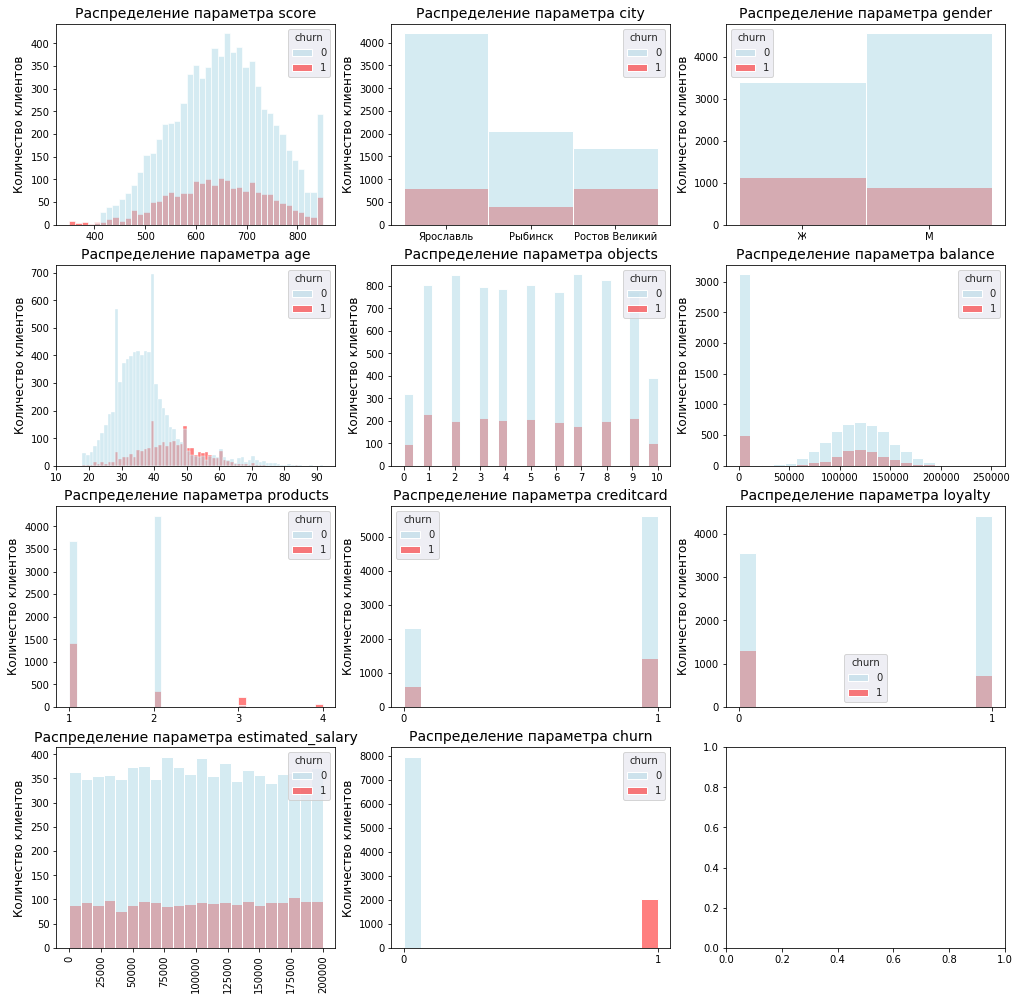

In [17]:
grid =  [(i, j) for i in range(4) for j in range(3)]
data_columns = data.drop(columns=['userid']).columns

fig, ax = plt.subplots(4, 3, figsize=(17, 17))
sns.set_style("darkgrid")
sns.set_palette(['lightblue','red'])

for position, column in zip(grid, data_columns):
    sns.histplot(x=column, hue="churn", data=data,ax=ax[position])
    ax[position].set_title('Распределение параметра {}'.format(column), fontsize=14)
    ax[position].set_xlabel('')
    ax[position].set_ylabel('Количество клиентов', fontsize=12)
    #ax[position].legend(['Ушли', 'Остались'])

ax[(1,0)].set_xticks(range(10,100,10)) # настроим ticks на графиках корректно
ax[(1,1)].set_xticks(range(0,11,1))
ax[(2,0)].set_xticks(range(1,5,1))
ax[(2,1)].set_xticks(range(0,2,1))
ax[(2,2)].set_xticks(range(0,2,1))
ax[(3,0)].set_xticklabels(range(-25000,250000,25000),rotation='vertical')
ax[(3,1)].set_xticks(range(0,2,1))

plt.show()

График по `balance` не информативен, нужно отфильтровать наши нули и нарисовать без них.

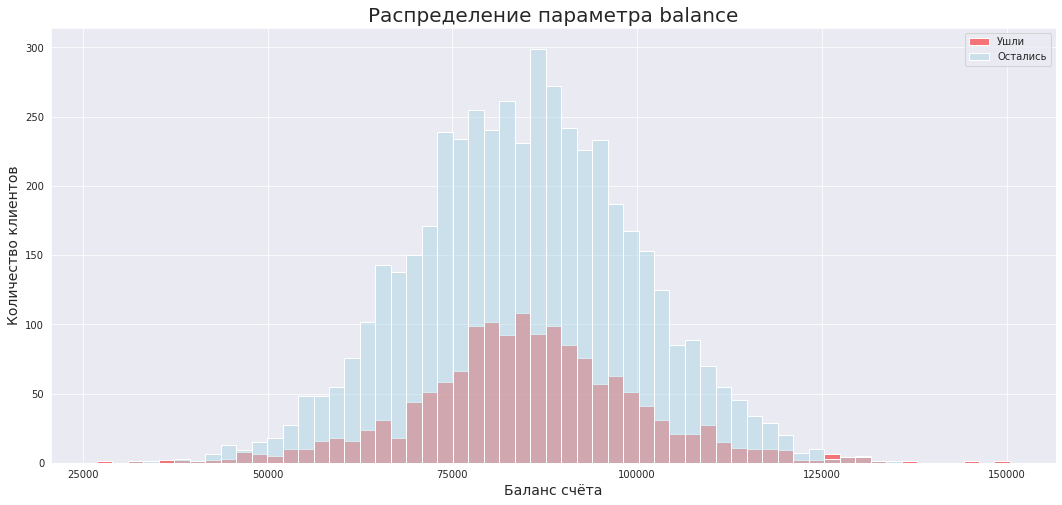

In [18]:
sns.set_style("darkgrid")
sns.set_palette(['lightblue','red'])
fig, ax = plt.subplots(figsize=(18, 8))  
ax = sns.histplot(x="balance", hue="churn", data=data.loc[data['balance'] > 0])
ax.set_title('Распределение параметра balance', fontsize=20)
ax.set_xlabel('Баланс счёта', fontsize=14)
ax.set_ylabel('Количество клиентов', fontsize=14)
ax.set_xticklabels(range(0,175000,25000))
plt.legend(['Ушли', 'Остались'])
plt.show()

**Можно делать промежуточные выводы:**

- `score`. Кредитный рейтинг распределен нормально, как среди оставшихся так и среди ушедших. Много клиентов с максимальным рейтингов в 850.

- `city`. Три города. Из Ярославля половина клиентов. В Ростове Великом самая большая доля оттока - около 50%.

- `gender`. Мужчин больше, чем женщин. Но среди женщин отток значительно выше.

- `age`. Оставшиеся клиенты в среднем моложе ушедших. Чем старше, тем доля оттока растет. Данные распределены нормально.

- `objects`. Тут все почти ровно. Настолько ровно, что даже странно. Я ожидал увидеть нормальное распределение с пиками 1 или 2, однако все не так. Интересно о каких объектах собственности тут речь?

- `balance`. Нормальные распределения по балансу счетов. Влияние не замечено.

- `products`. Почти все клиенты пользуются 1 или 2 продуктами. Клиенты, которые пользуются 3-4 продуктами уходят от банка.

- `creditcard`. Кредитками пользуется бОльшая часть клиентов. Отток среди пользующихся и непользующихся примерно сопоставим.

- `loyalty`. Среди неактивныех клиентов отток ожидаемо выше.

- `estimated salary`. Зарплата клиентов распредена достаточно ровно. Отток среди них тоже. Опять подозрительно.

- `churn`. Отток - 20%.

Оценим выбросы в количественных переменных.

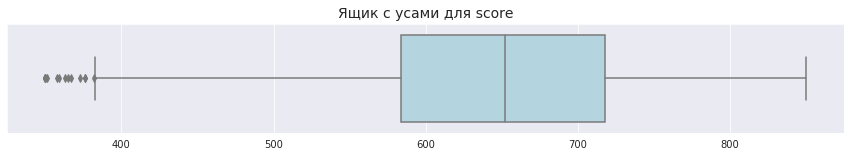

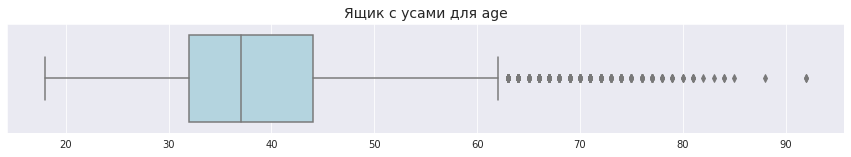

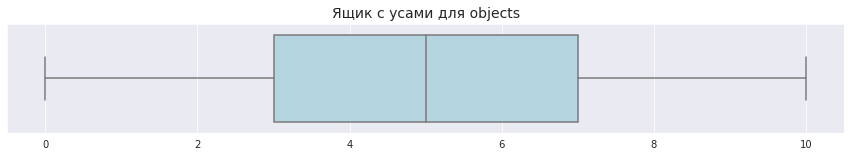

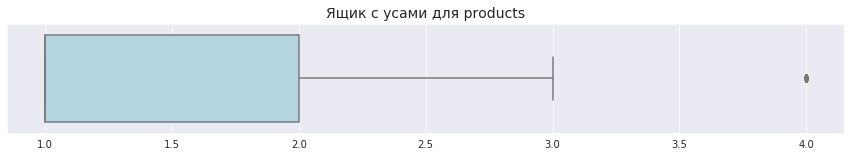

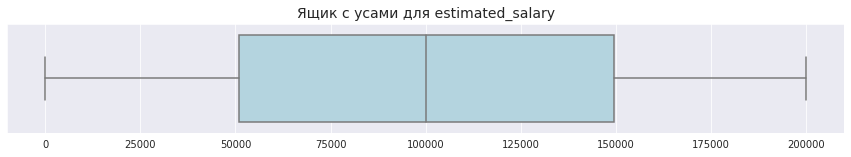

In [19]:
columnlist = ['score','age','objects','products','estimated_salary']
for column in columnlist:
    plt.figure(figsize=(15,2))
    sns.boxplot(data[column],orient="h")
    plt.title('Ящик с усами для {}'.format(column),fontsize=14)
    plt.xlabel('')
    plt.show()

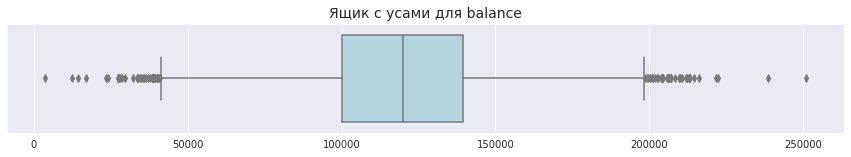

In [20]:
plt.figure(figsize=(15,2))
sns.boxplot(data = data[data['balance'] > 0],x='balance',orient="h")
plt.title('Ящик с усами для balance',fontsize=14)
plt.xlabel('')
plt.show()

Для `score` и `products` выбросы незначительны. Появляются они из-за скученности данных к медиане.

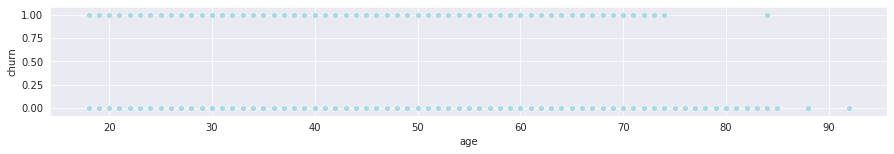

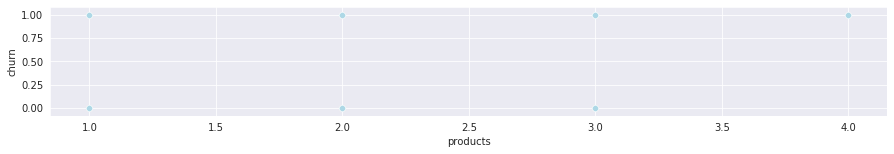

In [21]:
# посмотрим скэттеры
for column in ['age','products']:
    plt.figure(figsize=(15,2))
    sns.scatterplot(data[column], data['churn'])
    plt.show()

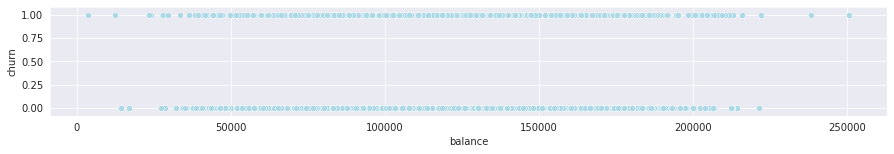

In [22]:
plt.figure(figsize=(15,2))
sns.scatterplot(data[data['balance'] > 0]['balance'], data['churn'])
plt.show()

По `balance` выбросы есть как в меньшую, так и в большую сторону. Причем у ушедших они амплитуднее.

In [23]:
data[data['balance'] > 0].groupby('churn').agg({'balance':['mean','median']})

balance            
                mean      median
churn                           
0      119535.864270  119791.215
1      120746.971132  119948.090

Чем дальше среднее от медианы, тем больше выбросов и их влияние. Здесь же средние и медианы практически совпадают. Выбросы по обоим сторонам уравновешивают друг друга, так сказать.

**Выводы**

## Шаг. Статистический анализ анализ данных.

**Гипотеза 1 - Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались.**

Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей по взятым из них выборкам, применим метод `scipy.stats.ttest_ind`. **Нулевая гипотеза** - равенство средних . Соответственно **альтернативная** - их различие.

Критерий Стьюдента(t-критерий) направлен на оценку равенства средних значений двух выборок, которые распределены по нормальному закону. Также важное условие состоит в равенстве дисперсий двух выборок.

Проверим данные на нормальное распределение

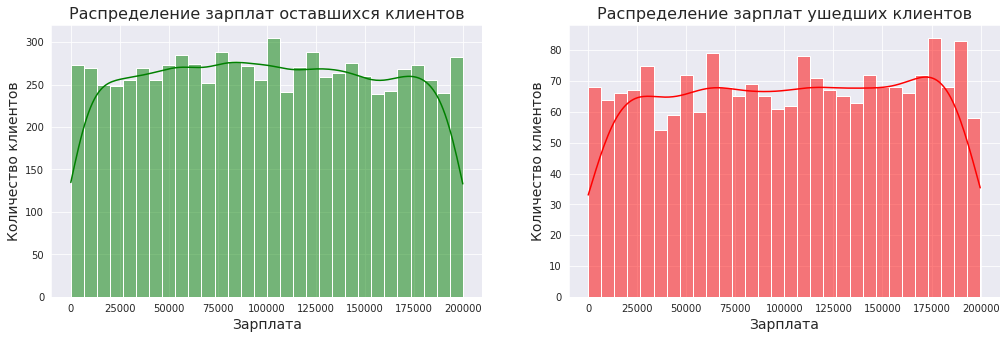

In [24]:
salary_churn_0 = data[data['churn'] == 0]['estimated_salary']
salary_churn_1 = data[data['churn'] == 1]['estimated_salary']
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.histplot(x=salary_churn_0, ax=ax[0], kde=True, color='green',bins=30)
sns.histplot(x=salary_churn_1, ax=ax[1], kde=True, color='red',bins=30)
ax[0].set_title('Распределение зарплат оставшихся клиентов',fontsize=16)
ax[1].set_title('Распределение зарплат ушедших клиентов',fontsize=16)
ax[0].set_xlabel('Зарплата',fontsize=14)
ax[0].set_ylabel('Количество клиентов',fontsize=14)
ax[1].set_xlabel('Зарплата',fontsize=14)
ax[1].set_ylabel('Количество клиентов',fontsize=14)
plt.show()

Данные имеют примерно равномерное распределение. Хотя казалось бы данные должны иметь нормальное распределение к какой-нибудь средней зарплате. Я ни за что не поверю, что количество людей с ЗП=50000 будет примерно равным количеству людей с ЗП=200000. Но данные есть данные. Поэтому, для такого распределения проведем сразу 2 теста: **t-тест Стьюдента** и **u-тест Манна-Уитни**.

Также имеет значение равенство дисперсий (распределения) выборок. При неравных дисперсиях применяется **t-критерий Уэлча**.

In [25]:
print('Средняя и медиана salary ушедших: \t{:.2f}\t{}'.format(salary_churn_1.mean(),salary_churn_1.median()))
print('Средняя и медиана salary оставшихся: \t{:.2f}\t{}'.format(salary_churn_0.mean(),salary_churn_0.median()))
print('-------------------------------------------------------------------------')
print('Дисперсия salary ушедших: \t{:.2f}'.format(salary_churn_1.var()))
print('Дисперсия salary оставшихся: \t{:.2f}'.format(salary_churn_0.var()))

Средняя и медиана salary ушедших: 	101465.68	102460.84
Средняя и медиана salary оставшихся: 	99738.39	99645.04
-------------------------------------------------------------------------
Дисперсия salary ушедших: 	3353848166.81
Дисперсия salary оставшихся: 	3295401414.92


In [26]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(salary_churn_0, salary_churn_1)
print('p-значение теста Стьюдента:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение теста Стьюдента: 0.22644042802223346
Не получилось отвергнуть нулевую гипотезу


In [27]:
alpha = 0.05
stat, p = mannwhitneyu(salary_churn_0, salary_churn_1)
print('p-значение теста Манна-Уитни:', p)
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение теста Манна-Уитни: 0.11352575465076892
Не получилось отвергнуть нулевую гипотезу


Похоже средние зарплаты находятся достаточно близко к друг другу. И тот и другой тест не смогли опровергнуть нулевую гипотезу. Вероятность далеко от уровня критической значимости и она достаточно высокая. Хоть средние могут быть и не одинаковы,такое различие может быть случайно.

**Гипотеза 2 - Гипотеза различия кредитного скоринга между теми же клиентами.**

Теперь проверим средние по `score` на сходство и различие. Опять-таки, **Нулевая гипотеза** - равенство средних . Соответственно **альтернативная** - их различие.

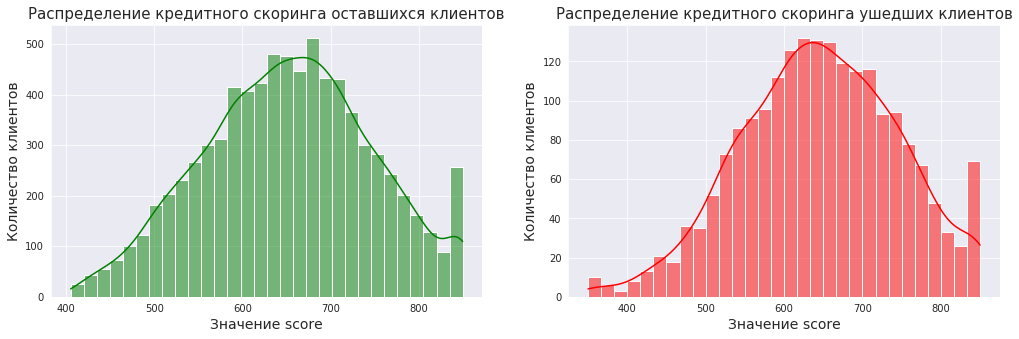

In [28]:
score_churn_0 = data[data['churn'] == 0]['score']
score_churn_1 = data[data['churn'] == 1]['score']

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.histplot(x=score_churn_0, ax=ax[0], kde=True, color='green',bins=30)
sns.histplot(x=score_churn_1, ax=ax[1], kde=True, color='red',bins=30)
ax[0].set_title('Распределение кредитного скоринга оставшихся клиентов',fontsize=15)
ax[1].set_title('Распределение кредитного скоринга ушедших клиентов',fontsize=15)
ax[0].set_xlabel('Значение score',fontsize=14)
ax[0].set_ylabel('Количество клиентов',fontsize=14)
ax[1].set_xlabel('Значение score',fontsize=14)
ax[1].set_ylabel('Количество клиентов',fontsize=14)
plt.show()

А вот здесь всё более менее предсказуемо и имеет нормальное распределение. Ограничимся t-тестом Стьюдента.

In [29]:
print('Средняя и медиана score ушедших: \t{:.2f}\t{}'.format(score_churn_1.mean(),score_churn_1.median()))
print('Средняя и медиана score оставшихся: \t{:.2f}\t{}'.format(score_churn_0.mean(),score_churn_0.median()))
print('-----------------------------------------------------')
print('Дисперсия score ушедших: \t{:.2f}'.format(score_churn_1.var()))
print('Дисперсия score оставшихся: \t{:.2f}'.format(score_churn_0.var()))

Средняя и медиана score ушедших: 	645.35	646.0
Средняя и медиана score оставшихся: 	651.85	653.0
-----------------------------------------------------
Дисперсия score ушедших: 	10064.40
Дисперсия score оставшихся: 	9149.66


Так как дисперсии не равны используем `equal_var=False` в параметрах теста (критерий Уэлча)

In [30]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(score_churn_0, score_churn_1,equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.008464728991832877
Отвергаем нулевую гипотезу


А вот здесь совсем другая картина. p-value чуть меньше 1%. Таким образом тест показывает, что средние наших групп отличаются. Хотя на первый взгляд они и очень близки. Уровень значимости попал в критический интервал. Статистически средние по выборкам сильно отклоняются друг от друга.

**Гипотеза 3 - Гипотеза различия возраста между теми же клиентами.**

Проверим средние по `age` на сходство и различие. Опять-таки, **Нулевая гипотеза** - равенство средних . Соответственно **альтернативная** - их различие.

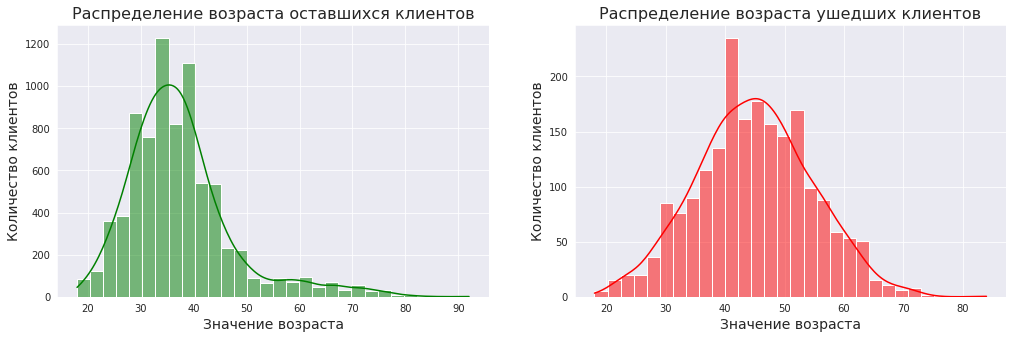

In [31]:
age_churn_0 = data[data['churn'] == 0]['age']
age_churn_1 = data[data['churn'] == 1]['age']

fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.histplot(x=age_churn_0, ax=ax[0], kde=True, color='green',bins=30)
sns.histplot(x=age_churn_1, ax=ax[1], kde=True, color='red',bins=30)
ax[0].set_title('Распределение возраста оставшихся клиентов',fontsize=16)
ax[1].set_title('Распределение возраста ушедших клиентов',fontsize=16)
ax[0].set_xlabel('Значение возраста',fontsize=14)
ax[0].set_ylabel('Количество клиентов',fontsize=14)
ax[1].set_xlabel('Значение возраста',fontsize=14)
ax[1].set_ylabel('Количество клиентов',fontsize=14)
plt.show()

Уже на графиках видно, что пики распределений возраста у групп различаются.

In [32]:
print('Средняя и медиана возраста ушедших: \t{:.2f}\t{}'.format(age_churn_1.mean(),age_churn_1.median()))
print('Средняя и медиана возраста оставшихся: \t{:.2f}\t{}'.format(age_churn_0.mean(),age_churn_0.median()))
print('-----------------------------------------------------')
print('Дисперсия возраста ушедших: \t{:.2f}'.format(age_churn_1.var()))
print('Дисперсия возраста оставшихся: \t{:.2f}'.format(age_churn_0.var()))

Средняя и медиана возраста ушедших: 	44.84	45.0
Средняя и медиана возраста оставшихся: 	37.41	36.0
-----------------------------------------------------
Дисперсия возраста ушедших: 	95.29
Дисперсия возраста оставшихся: 	102.52


In [33]:
alpha = 0.05  # критический уровень статистической значимости
results = st.ttest_ind(age_churn_0, age_churn_1,equal_var=False)
print('p-значение теста Стьюдента:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение теста Стьюдента: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


p-value очень мал. Нет никаких шансов говорить,что средние у этих групп похожи.

**Выводы:**

По итогам проверки гипотез можно точно сказать про сходства\различия между оставшимися клиетами и ушедшими.
- По доходу средние по группам близки.

- По значению кредитного скоринга группы отличаются. У ушедших среднее значение параметра меньше.

- По возрасту группы отличаются. У ушедших средний возраст больше.

## Шаг. Модели предсказания оттока клиентов.

Для моделей машинного обучения преобразуем текстовые данные в числовые. Приведем их к бинарным и категориальным.

In [34]:
data_ml = data.copy()
data_ml['gender'] = data_ml['gender'].map({'Ж':0, 'М':1})
data_ml['city'] = data_ml['city'].map({'Ярославль':0, 'Рыбинск':1, 'Ростов Великий':2})
data_ml = data_ml.drop('userid', axis = 1)

Возникает дилемма что делать с нулями в `balance`. Можно удалить эти 3700 строк, но вместе с ними удалятся и другие полезные данные (3700*10 = примерно 37000 значений). Другой вариант - удалить только параметр `balance` (10000 значений). Логичнее удалить один параметр.

In [35]:
data_ml = data_ml.drop('balance', axis = 1)
data_ml.duplicated().sum() # и проверим на дубли еще раз

0

In [36]:
corr = data_ml.corr() # посмотрим матрицу корреляций

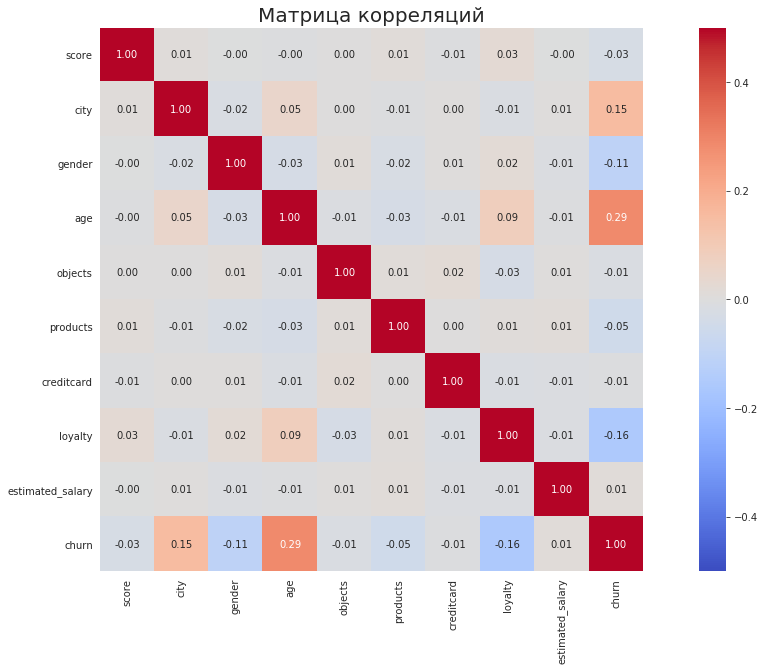

In [37]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot = True, square=True, fmt='.2f', vmin=-0.5, vmax=0.5,cmap='coolwarm')
plt.title('Матрица корреляций',fontsize=20)
plt.show()

Данные слабо коррелируют между собой. Целевая переменная `churn` больше всего коррелирует с `age`,`city`,`loyalty` и `gender`.

In [38]:
X = data_ml.drop(columns='churn',axis = 1)
y = data_ml['churn']

In [39]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


# Функция тренирует модель m на тестовых данных и рассчитывает все необходимые метрики
def train_model(m):
    print(m)
    model = m
    model.fit(X_train_st,y_train)
    predictions = model.predict(X_test_st)
    probabilities = model.predict_proba(X_test_st)[:, 1]
    print('\nAccuracy:  {:.2f}'.format(accuracy_score(y_test, predictions)), 
          '\nPrecision: {:.2f}'.format(precision_score(y_test, predictions)),
          '\nRecall:    {:.2f}'.format(recall_score(y_test, predictions)),
          '\nF1:        {:.2f}' .format(f1_score(y_test, predictions)),
          '\nROC_AUC:   {:.2f}'.format(roc_auc_score(y_test, probabilities)),'\n')


In [40]:
# вызываем функцию для двух моделей
for model in [LogisticRegression(random_state = 0),
              RandomForestClassifier(n_estimators = 100, random_state = 0)]:
    train_model(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy:  0.81 
Precision: 0.61 
Recall:    0.21 
F1:        0.31 
ROC_AUC:   0.76 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Accuracy:  0.86 
Precision: 0.74 
Recall:    0.49 
F1:        0.59 
ROC_AUC:   0.84 



- Accuracy (точность прогнозирования)
- Precision (доля правильных ответов в пределах класса)
- Recall (количесто истиннопозитивных результатов)
- F1 (обобщеная оценка метрик Precision и Recall)
- ROC_AUC (площадь под кривой ошибок)

Судя по метрикам, модель случайного леса показывает себя намного лучше модели логистической регрессии. Самые важные метрики для нас `Recall` и `F1`. По ним ним модель случайного леса правильно предсказывает больше половины результатов. Модель логистической регрессии предсказывает значительно хуже.

In [41]:
# важность признаков
importance = pd.DataFrame({'feature': X.columns, 'importance':model.feature_importances_})
importance.sort_values(by='importance', ascending=False)

,feature,importance
3,age,0.260192
8,estimated_salary,0.197400
0,score,0.188851
5,products,0.129577
4,objects,0.096895
1,city,0.045820
7,loyalty,0.039099
6,creditcard,0.022002
2,gender,0.020163


Самый важный признак для модели - `age`. Модель подтверждает исседовательский анализ. `estimated_salary` и `score` тоже имеют повышенную важность. А вот `gender` наименее влиятельный признак для модели. В исследовательском анализе видно,что женщины более скронны к оттоку, а модель говорит, что это не так.

**Кластеризация.**

- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика увидим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
- Посмотрим на средние значения признаков для кластеров.
- Построим распределения признаков для кластеров.

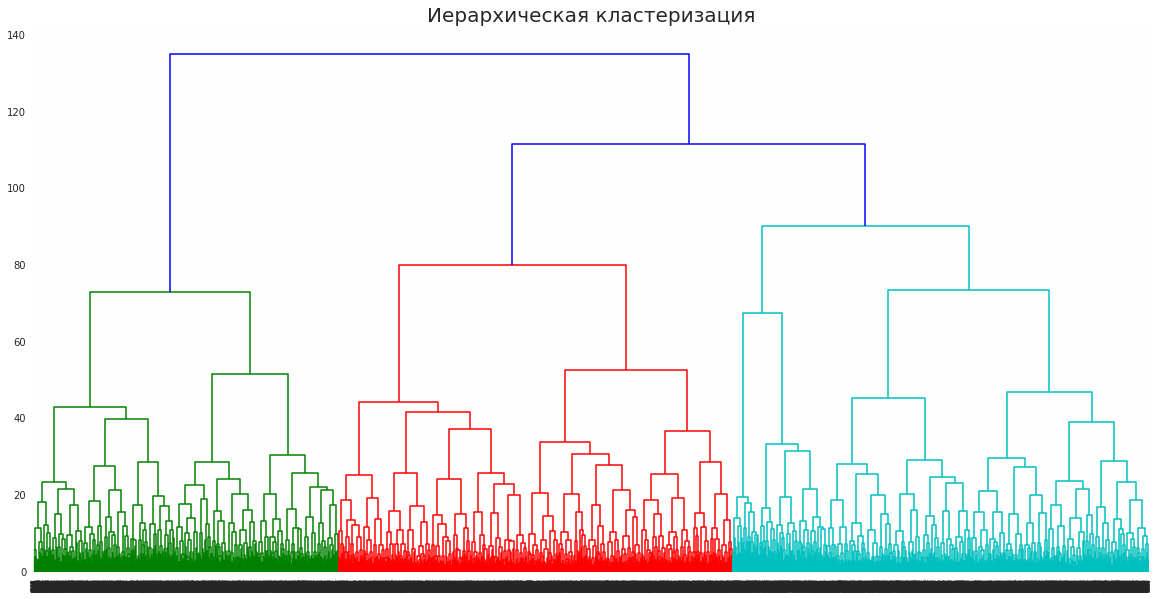

In [42]:
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method='ward')
plt.figure(figsize=(20, 10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=20)
plt.show()

Модель выделила 3 кластера.

In [43]:
km = KMeans(n_clusters = 3, random_state = 0)
labels = km.fit_predict(X_st)
data['cluster'] = labels

In [44]:
clusters_data = data.drop(['balance','city'],axis = 1)
clusters_data['gender'] = clusters_data['gender'].map({'Ж':0, 'М':1})

In [45]:
clusters_data.groupby('cluster').agg({'userid': 'nunique',
                                       'score': 'median',
                                       'gender': 'mean',
                                       'age': 'median',
                                       'objects': 'mean',
                                       'products': 'mean',
                                       'creditcard': 'mean',
                                       'loyalty': 'mean',
                                       'estimated_salary': 'mean',
                                       'churn': 'mean',
                             })

,userid,score,gender,age,objects,products,creditcard,loyalty,estimated_salary,churn
cluster,,,,,,,,,,
0,3192,651,0.000000,38,4.990602,1.543860,1,0.497180,99866.690188,0.249060
1,3863,651,1.000000,37,5.108206,1.521098,1,0.522910,99600.911848,0.162827
2,2945,654,0.541256,38,4.911715,1.527334,0,0.524278,100974.397711,0.208149


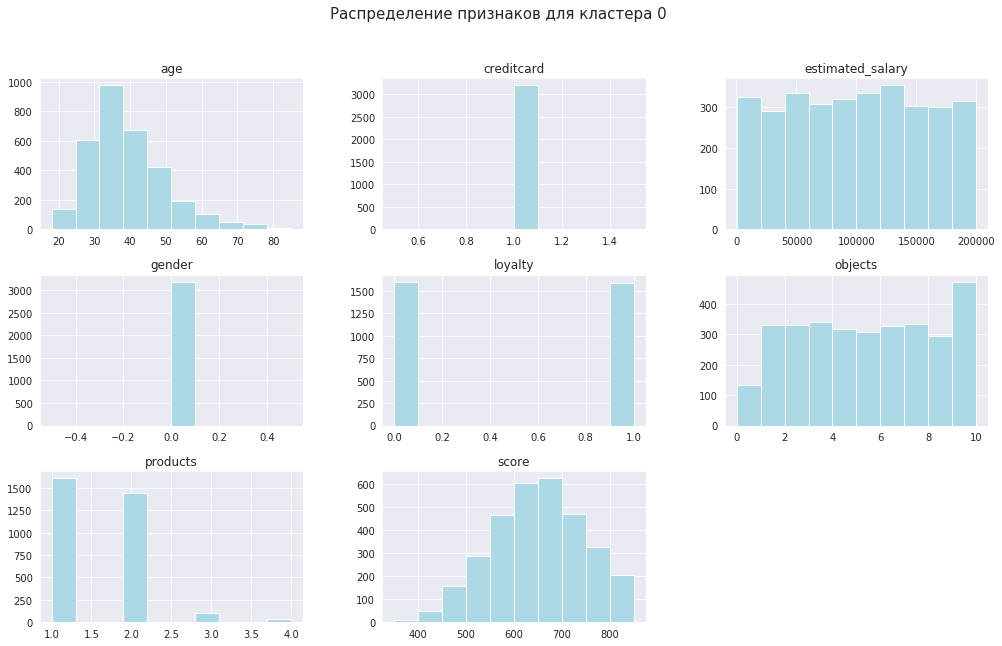

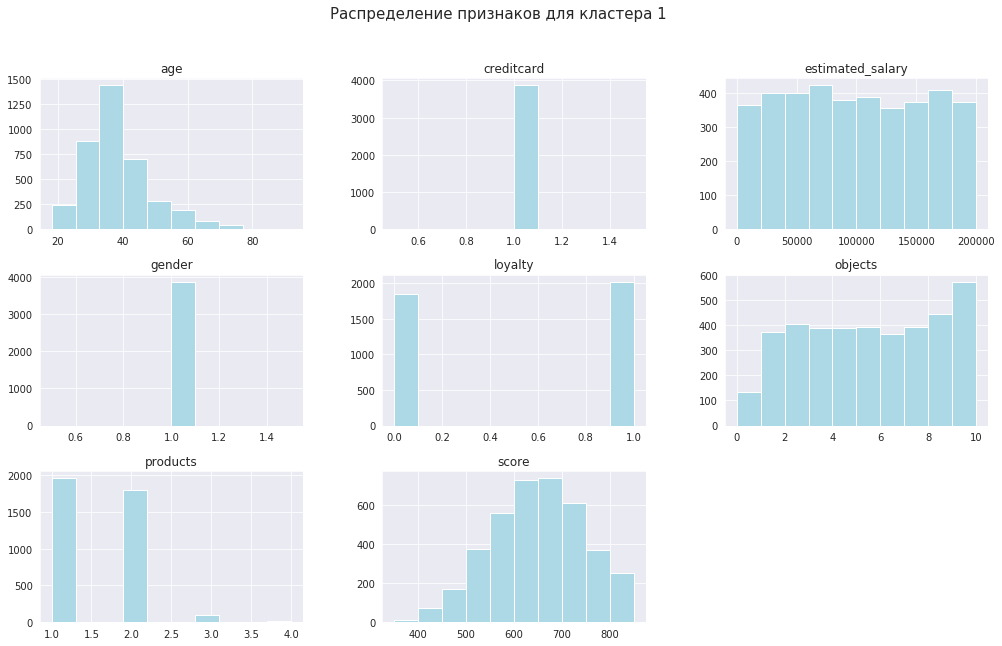

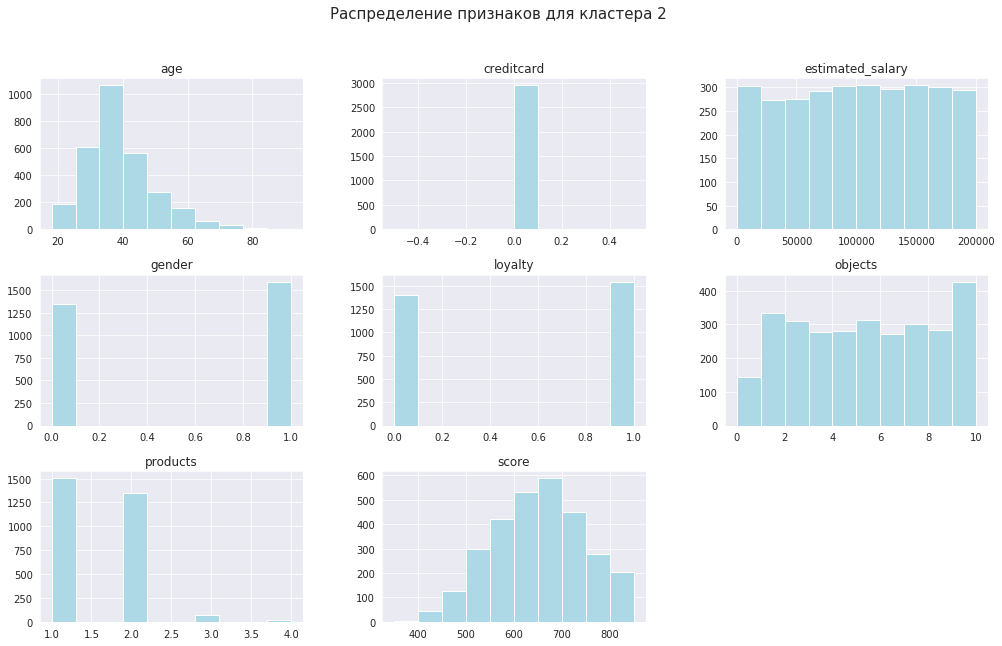

In [46]:
for cluster in [0, 1, 2]: # переберем кластеры
    clusters_data[clusters_data['cluster']==cluster].drop(['userid','churn','cluster'], axis=1).hist(figsize=(17,10))
    plt.suptitle('Распределение признаков для кластера {}'.format(cluster), fontsize = 15)
    plt.ylabel('count')
    plt.show()

0 кластер - Только женщины, объектов в собственности выброс на 10, паритет по лояльности, остальные параметны примерно также распределены как у всех. Отток - 25%.

1 кластер - Только мужчины, объектов в собственности также выброс на 10, остальные параметры похожи. Отток - 16%.

2 кластер - Мужчин побольше,чем женщин, кредитной картой не пользуются, остальные параметры похожи. Отток - 20%.

Честно говоря, модель кластеризации никаких новых идей не дала и сработала недостаточно хорошо.

**Выводы**

Честно говоря, модель кластеризации никаких новых идей не дала и сработала недостаточно хорошо. Единственное, показывает, что по мужчинам отток 16%, по женщинам - 25% в среднем. Модель случайного леса показал нам ключевые признаки по важности влияния на целевую переменную. Самые важные - `age`, `estimated_salary` и `score`. Единственное, если посмотреть на распределение зарплат, то сильного влияния на отток незаметно(отток примерно постоянен).

## Шаг. Итоги.

Проведен исследовательский анализ признаков наших клиентов. Выделены ключевые точки, где отток различается.

Проведен статистический анализ некоторых признаков на равенство их средних.

Обучили 2 модели прогнозирования целевой переменной отток. Результаты прогнозирования слабые. Возможно для обучения моделей нужно больше данных.

Поделили клиентов на кластеры и узнали как изменяется целевая переменная в зависимости от кластера.


По итогом анализа выделим несколько признаков, которые больше всего влияют на целевую переменную `churn`:

- `age` С возрастом клиента, вероятность  тоже оттока растёт. Особенно после 45 лет. Смерть клиента тоже считается за отток.

- `gender` Мужчины менее подвержены оттоку, нежели женщины.

- `score` Статистический анализ показывает, что средние по группам не равны. А значит этот параметр тоже влияет на отток.

- `loyalty` Лояльные и активные клиенты намного менее подвержены оттоку, чем нелояльные.

- `creditcard` Клиенты с кредитной картой менее склонны к оттоку. Кредитка - удобный инструмент, если знать как и правильно её использовать.

- `products` Большинство клиентов пользуются 1-2 продуктами банка. Причем среди пользователей с 2 продуктами показатель оттока самый низкий. С 3-4 продуктами пользователей намного меньше и показатель оттока среди них катастрофически высок.

- `city` В Ростове Великом существенно больший отток клиентов, чем в остальных городах.

**Рекомендации:**

- Увеличивать лояльность, привлекать клиентов к более активному использованию приложения/продуктов банка.

- Не перегружать клиента продуктами. Людям это не нравится. Возможно стоит информировать клиентов о том или ином продукте рассылками.

- Людям 45+ нужны стимулы/отдельная программа лояльности, чтобы удержать их.

- Продолжать работать с кредитными картами, чтобы сделать условия еще более привлекательными.

- Отдельно проверить работу банка и процессы в Ростове Великом, велика вероятность что, что-то там работает не так как должно.

- Ввести/проработать программу кэшбека по картам. Во-первых,люди любят кэшбек. Во-вторых, поможет привлечь больше клиентов других банков. В-третьих, повысить лояльность и снизить отток уже действующих клиентов нашего банка.

- По возможности поддерживать и предлагать лучшие условия по продуктам банка среди остальных банков.

- Более активно рекламировать услуги банка с наших городах.